In [1]:
import sys
import json
import os
import string
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader

if r'G:\PythonProjects\WineRecognition2' not in sys.path:
    sys.path.insert(0, r'G:\PythonProjects\WineRecognition2')

from nn.utils import generate_tag_to_ix, get_model_confidence, get_model_mean_confidence, CustomDataset
from nn.mlflow_utils import log_mlflow_on_test
from nn.model import BiLSTM_CRF
from data_master import DataGenerator, count_unk_foreach_tag, DataAnalyzer
from tqdm.notebook import tqdm

import wandb

from sklearn_crfsuite import metrics

D:\ProgramFiles\anaconda3\envs\wine-recognition\lib\site-packages\papermill\iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
TRAIN_RUN_ID = 'g62qoutw'
RUN_NAME = 'Test-100-256'
START_TIME = ''
OUTPUT_DIR = 'G:/PythonProjects/WineRecognition2/artifacts/test/test'
DATA_PATH = r'G:\PythonProjects\WineRecognition2\data\text\menu_txt_tagged_fixed_bottlesize.txt'
COMPUTE_METRICS = True
DEVICE = 'cpu'

In [4]:
wandb_api = wandb.Api()
train_run = wandb_api.run(f'mentalakv/wine-recognition/{TRAIN_RUN_ID}')

logged_artifacts = train_run.logged_artifacts()
train_run_params = train_run.config

In [8]:
artifact_dict = {}
for artifact in logged_artifacts:
    artifact_dict[artifact.name.split(':')[0]] = artifact

artifact_dict['best_model'].download(OUTPUT_DIR)
artifact_dict['vocab'].download(OUTPUT_DIR)
artifact_dict['tags'].download(OUTPUT_DIR)

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


'G:/PythonProjects/WineRecognition2/artifacts/test/test'

In [9]:
params = {
    'train_run_id': TRAIN_RUN_ID,
    'data_path': DATA_PATH,
    'compute_metrics': COMPUTE_METRICS,
    'device': DEVICE,
    'run_info': {
        'name': RUN_NAME,
        'output_directory': OUTPUT_DIR,
        'start_time': START_TIME
    },
    'train_run_parameters': train_run_params
}

wandb.init(
    project="wine-recognition",
    config=params,
    tags=[train_run_params['model_name'], 'test'],
    dir=OUTPUT_DIR
)

wandb: Currently logged in as: mentalakv. Use `wandb login --relogin` to force relogin


In [10]:
with open(os.path.join(OUTPUT_DIR, 'vocab.json'), 'r', encoding='utf-8') as file:
    word_to_ix = json.load(file)

vocab_size = len(word_to_ix) 
    
vocab_size

18208

In [11]:
with open(os.path.join(OUTPUT_DIR, 'tags.json')) as file:
    tag_to_ix = json.load(file)
    
num_tags = len(tag_to_ix)

if not COMPUTE_METRICS:
    tag_to_ix['UNKNOWN'] = max(tag_to_ix.values()) + 1

ix_to_tag = {value: key for key, value in tag_to_ix.items()}
tag_to_ix

{'Add_TradeName': 0,
 'Add_Brand': 1,
 'Add_KeyWordTrue': 2,
 'Add_KeyWordFalse': 3,
 'Add_GrapeVarieties': 4,
 'Add_GeoIndication': 5,
 'Add_WineType': 6,
 'Add_BottleSize': 7,
 'Add_Sweetness': 8,
 'Add_WineColor': 9,
 'Add_ClosureType': 10,
 'Add_Certificate': 11,
 'Add_Vintage': 12,
 'Add_Price': 13,
 'Punctuation': 14,
 'Other': 15}

In [12]:
with open(DATA_PATH, encoding='utf-8') as file:
    x_test = DataGenerator.generate_sents2(file.read().split('\n'))

    
dataset = CustomDataset(
    x_test,
    tag_to_ix,
    word_to_ix,
    case_sensitive=train_run_params['case_sensitive_vocab'],
    convert_nums2words=train_run_params['use_num2words']
)

y_test = [tags for _, tags in dataset.raw_data()]
dataloader = DataLoader(dataset, batch_size=2048, shuffle=False, drop_last=False)

In [14]:
model = BiLSTM_CRF(vocab_size, num_tags, train_run_params['embedding_dim'], train_run_params['hidden_dim'], word_to_ix['PAD'])
model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'model.pth')))
model = model.to(DEVICE)
model.eval()

BiLSTM_CRF(
  (embedding): Embedding(18208, 64, padding_idx=18173)
  (lstm): LSTM(64, 64, batch_first=True, bidirectional=True)
  (hidden2tags): Linear(in_features=128, out_features=16, bias=True)
  (crf): CRF(num_tags=16)
)

In [15]:
y_pred = []
with torch.no_grad():
    for x, tags, mask, _ in dataloader:
        x = x.to(DEVICE)
        tags = tags.to(DEVICE)
        mask = mask.to(DEVICE)
        best_tag_seq = model(x, mask)
        y_pred.extend(best_tag_seq)

In [16]:
x_tensor = [
    torch.tensor(dataset.sentence_to_indices(sentence), dtype=torch.int64) for sentence, _ in dataset.raw_data()
]

In [17]:
unk_foreach_tag = count_unk_foreach_tag(x_tensor, y_test, list(tag_to_ix), dataset.word_to_ix[dataset.unk])

unk_foreach_tag_path = os.path.join(OUTPUT_DIR, 'unk_foreach_tag.json')
with open(unk_foreach_tag_path, 'w', encoding='utf-8') as file:
    json.dump(unk_foreach_tag, file)

unk_foreach_tag_artifact = wandb.Artifact('unk_foreach_tag', type='results')
unk_foreach_tag_artifact.add_file(unk_foreach_tag_path, 'unk_foreach_tag.json')
wandb.log_artifact(unk_foreach_tag_artifact)

<Artifact unk_foreach_tag>

In [18]:
conf = get_model_mean_confidence(model, x_tensor, DEVICE, tqdm)

0it [00:00, ?it/s]

D:\ProgramFiles\anaconda3\envs\wine-recognition\lib\site-packages\torchcrf\__init__.py:305: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  ..\aten\src\ATen\native\TensorCompare.cpp:328.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)


In [19]:
for index, pred in enumerate(y_pred):
    y_pred[index] = [ix_to_tag[tag] for tag in pred]

x_test = [sentence for sentence, _ in dataset.raw_data()]

In [21]:
labels=list(tag_to_ix)

wandb.log({'metrics': {
    'f1': metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=labels),
    'precision': metrics.flat_precision_score(y_test, y_pred, average='weighted', labels=labels),
    'recall': metrics.flat_recall_score(y_test, y_pred, average='weighted', labels=labels),
    'accuracy': metrics.flat_accuracy_score(y_test, y_pred),
    'confidence': conf
}})

flat_class_report_path = os.path.join(OUTPUT_DIR, 'flat-classification-report.txt')
with open(flat_class_report_path, 'w', encoding='utf-8') as file:
    file.write(metrics.flat_classification_report(y_test, y_pred, labels=labels, digits=3))
    
flat_class_report_artifact = wandb.Artifact('flat_classification_report', type='results')
flat_class_report_artifact.add_file(flat_class_report_path, 'flat_classification_report.txt')
wandb.log_artifact(flat_class_report_artifact)

D:\ProgramFiles\anaconda3\envs\wine-recognition\lib\site-packages\sklearn\metrics\_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
D:\ProgramFiles\anaconda3\envs\wine-recognition\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramFiles\anaconda3\envs\wine-recognition\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramFiles\anaconda3\envs\wine-recognition\lib\site-packages\sk

<Artifact flat_classification_report>

In [22]:
results_path = os.path.join(OUTPUT_DIR, 'results.txt')
with open(results_path, 'w', encoding='utf-8') as file:
    for sentence, tags in zip(x_test, y_pred):
        f = ['%-20s'] * len(sentence)
        file.write(' '.join(f) % tuple(tags) + '\n')
        file.write(' '.join(f) % tuple(sentence) + '\n')
        
results_artifact = wandb.Artifact('model_output', type='results')
results_artifact.add_file(results_path, 'model_output.txt')
wandb.log_artifact(results_artifact)

<Artifact model_output>

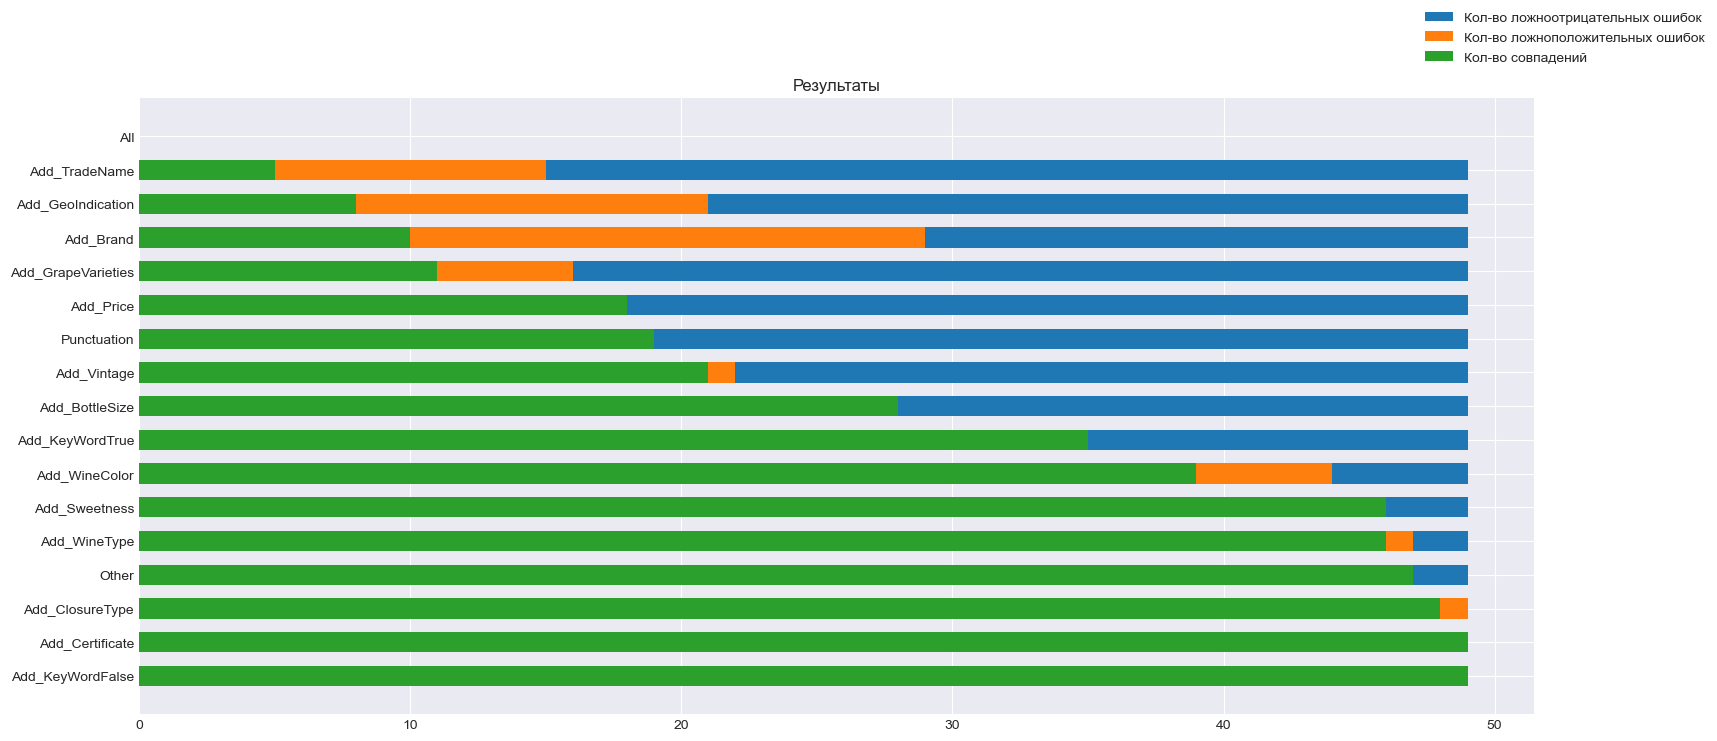

In [23]:
if COMPUTE_METRICS:
    test_eval = []
    for sentence, true_tags, pred_tags in zip(x_test, y_test, y_pred):
        test_eval.append(list(zip(sentence, true_tags, pred_tags)))
        
    colored_table_path = os.path.join(OUTPUT_DIR, 'colored-table.xlsx')
    diagram_path = os.path.join(OUTPUT_DIR, 'diagram.png')

    DataAnalyzer.analyze(
            test_eval,
            keys=labels,
            table_save_path=colored_table_path,
            diagram_save_path=diagram_path)
    
    colored_table_artifact = wandb.Artifact('colored_table', type='results')
    colored_table_artifact.add_file(colored_table_path, 'colored-table.xlsx')
    wandb.log_artifact(colored_table_artifact)

    diagram_artifact = wandb.Artifact('diagram', type='results')
    diagram_artifact.add_file(diagram_path, 'diagram.png')
    wandb.log_artifact(diagram_artifact)

In [24]:
df = []
classes = list(ix_to_tag.values())
for sentence, tags in zip(x_test, y_pred):
    output = [' '.join(word for word, tag in zip(sentence, tags) if tag == cls) for cls in classes]
    df.append(output)

source_strings = [' '.join(sentence) for sentence in x_test]
results_xlsx_path = os.path.join(OUTPUT_DIR, 'results.xlsx')
with pd.ExcelWriter(results_xlsx_path, engine='xlsxwriter') as writer:
    pd.DataFrame(df, columns=classes).to_excel(writer, sheet_name='results')
    pd.DataFrame(source_strings).to_excel(writer, sheet_name='source')

result_xlsx_table_artifact = wandb.Artifact('result_xlsx_table', type='results')
result_xlsx_table_artifact.add_file(results_xlsx_path, 'result_xlsx_table.xlsx')
wandb.log_artifact(result_xlsx_table_artifact)

<Artifact result_xlsx_table>

In [25]:
wandb.finish()